<a href="https://colab.research.google.com/github/IshaniBari/Classification-of-Natural-Scenes-for-Unmanned-Aerial-Vehicles-UAVs/blob/main/AI2_4Folds_Project_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 align='center'><b>PROJECT TITLE - Classification of Natural Scenes for an Unmanned Aerial Vehicles (UAVs)</b></h3>

**Team Name - 4 Folds**

**Team Members** -<br>
*   Heera Lal
*   Ishani Bari
*   Muhammad Akmal 
*   Umang Agarwal



**PROBLEM STATEMENT** - <br>
To predict the natural scenes around the flying object to tune the unmanned aerial systems.

**DESCRIPTION** - <BR>
Unmanned Aerial Vehicles requires the information about the surrounding scene to operate in its optimal conditions. We are trying to build a model to classify natural scenes that the object might encounter. -<br>

**DATASET** -<br>
This Data contains around 14k training images, 3k images for test and some images for prediction of size 150x150 distributed under 6 categories.<br>
Buildings : 0<br>
Forest    : 1<br>
Glacier   : 2<br>
Mountain  : 3<br>
Sea       : 4<br>
Street    : 5 


**OUR APPROACH TO THIS PROBLEM STATEMENT**-<br>
We tried 2 approches for this considering that we are building a model for UAV's to classify natural scenes -<br>
<U>**APPROACH 1**</U> -<br>
* Read the data from train and test directories as array into size of **64X64** (so as to reduce the training time and induce some noise in image) into X_train,y_train, X_test and y_test where X_train and X_test would contain images and y_train and y_test would contain corresponding labels. 
* Took **200 images from each class** and merged these images so total of **1200 images** and performed **5 Data Augmentation** (rotation, zoom, brightness, shear and night vision) on these 1200 images (like each of these 5 augmentations on 1200 images). After augmentation, we have 6000 augmented images **(1200 X 5)**, so we concatenated these 6000 images to X_train. Now, the X_train has **14k+6k** images for **training**.
* **CNN Model Architectures** - Tried 3 different model architectures.
* Model Evaluation and model selection.
* Visualization **(Saliency Maps and GradCAM)**
* Took 2 images from prediction data and tried predicting its class.


<U>**APPROACH 2**</U> -<br>
* Defined different functions for performing different augmentations - **(rotation, zoom, brightness, shear and night vision)**.
* Defined a funtion to **perfrom 2 to 5 augmentations randomly** on the each image. 

#### **Importing the Required Libraries**

In [ ]:
!pip3 -qq install tf_keras_vis 

In [ ]:
# Importing the required libraries
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


import os
import math
import random

from IPython.display import Image
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score , classification_report
from sklearn.model_selection import train_test_split


from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
import visualkeras


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, InputLayer, ReLU , BatchNormalization

%matplotlib inline
%matplotlib inline

In [ ]:
# Creating dictionary to turn different scenes index into class labels
scenedict = {
     0 : 'buildings',
     1 : 'forest',
     2 : 'glacier',
     3 : 'mountain',
     4 : 'sea',
     5 : 'street',
}
n_classes = len(scenedict.keys())

print('Total Classes: ',n_classes)
pd.DataFrame({"Keys" : scenedict.keys(),
              "Labels" : scenedict.values()})

Total Classes:  6


Keys     Labels
0     0  buildings
1     1     forest
2     2    glacier
3     3   mountain
4     4        sea
5     5     street

<h2><U><b>APPROACH 1</b></U> </h2>

#### 1. Loading Train and Test Sets

In [ ]:
# Defining a function get_data (images) from a given data directory 
# resize it to target size i.e. (64,64) and store the images in labels separately
def get_data(data_dir):
    train_img = []
    train_label = [] 
    for label in os.listdir(data_dir):
        lab = label
        for img_id in os.listdir('/'.join([data_dir, label])):
            img = load_img('/'.join([data_dir, label, img_id]), target_size=(64,64))
            img = img_to_array(img)
            train_img.append(img)
            train_label.append(lab)
    return train_img , train_label

In [ ]:
# Getting the train_data in train_dir
train_data_path = r'C:\Users\UMANG\AI-2\Project\OG_Data'
train_dir = os.path.join(train_data_path,'seg_train')

# Getting the test_data in test_dir
test_dir = os.path.join(train_data_path,'seg_test')

Loading the train data as images and labels using the get_data function defined above

In [ ]:
# Loading the train data in using the get_data function defined above
# in X_train which would be images and y_train which would be labels corresponding to images
X_train , y_train = get_data(train_dir)

# Scaling the X_train (images)
X_train = np.array(X_train) / 255

# Converting the labels in y_train to an array
y_train = np.array(y_train)

# Shuffling the X_train and y_train as now it would be in order that is
# first all images would be of one certain class, then other few images of 
# other certain class and so on.
# So shuffling the images and its labels
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [ ]:
# Checking the dimension of X_train and y_train
print("Shape of X_train : {} | Shape of Y_train : {}".format(X_train.shape , y_train.shape))


Shape of X_train : (14034, 64, 64, 3) | Shape of Y_train : (14034,)


The train data has about 14k images each of dimension (64,64,3)

Loading the test data in the same way as we did for train data as images and labels using the get_data function defined above.

In [ ]:
# Loading the test data in using the get_data function defined above
# in X_test which would be images and y_test which would be labels corresponding to images
#test_dir = r"C:\Users\UMANG\AI-2\Project\seg_test"
X_test , y_test = get_data(test_dir)

# Scaling the X_test (images)
X_test = np.array(X_test) / 255

# Converting the labels in y_test to an array
y_test = np.array(y_test)

# Shuffling the X_test and y_test as now it would be in order that is
# first all images would be of one certain class, then other few images of 
# other certain class and so on.
# So shuffling the images and its labels
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [ ]:
# Checking the dimension of X_test and y_test
print("Shape of X_test : {} | Shape of Y_test : {}".format(X_test.shape , y_test.shape))

Shape of X_test : (3000, 64, 64, 3) | Shape of Y_test : (3000,)


The test data has 3k images each of dimension (64,64,3)

#### 2. Data Visualisation 

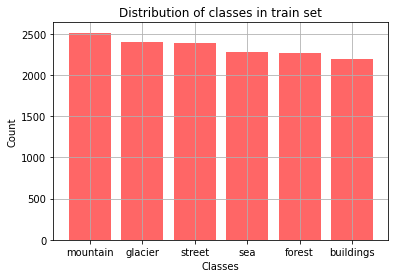

In [ ]:
# Checking the distribution of classes in train set

# Creating a label_df to store labels of X_train images
label_df = pd.DataFrame({"Label" : y_train})

# Plotting a bar chart
x = label_df['Label'].value_counts().keys()
y = label_df['Label'].value_counts().values
plt.bar(x,y , color = 'r' , alpha = 0.6)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of classes in train set')
plt.grid()

As seen from the above plot, the class distribution is not much imbalanced in the training set with each class having around 2300 images.

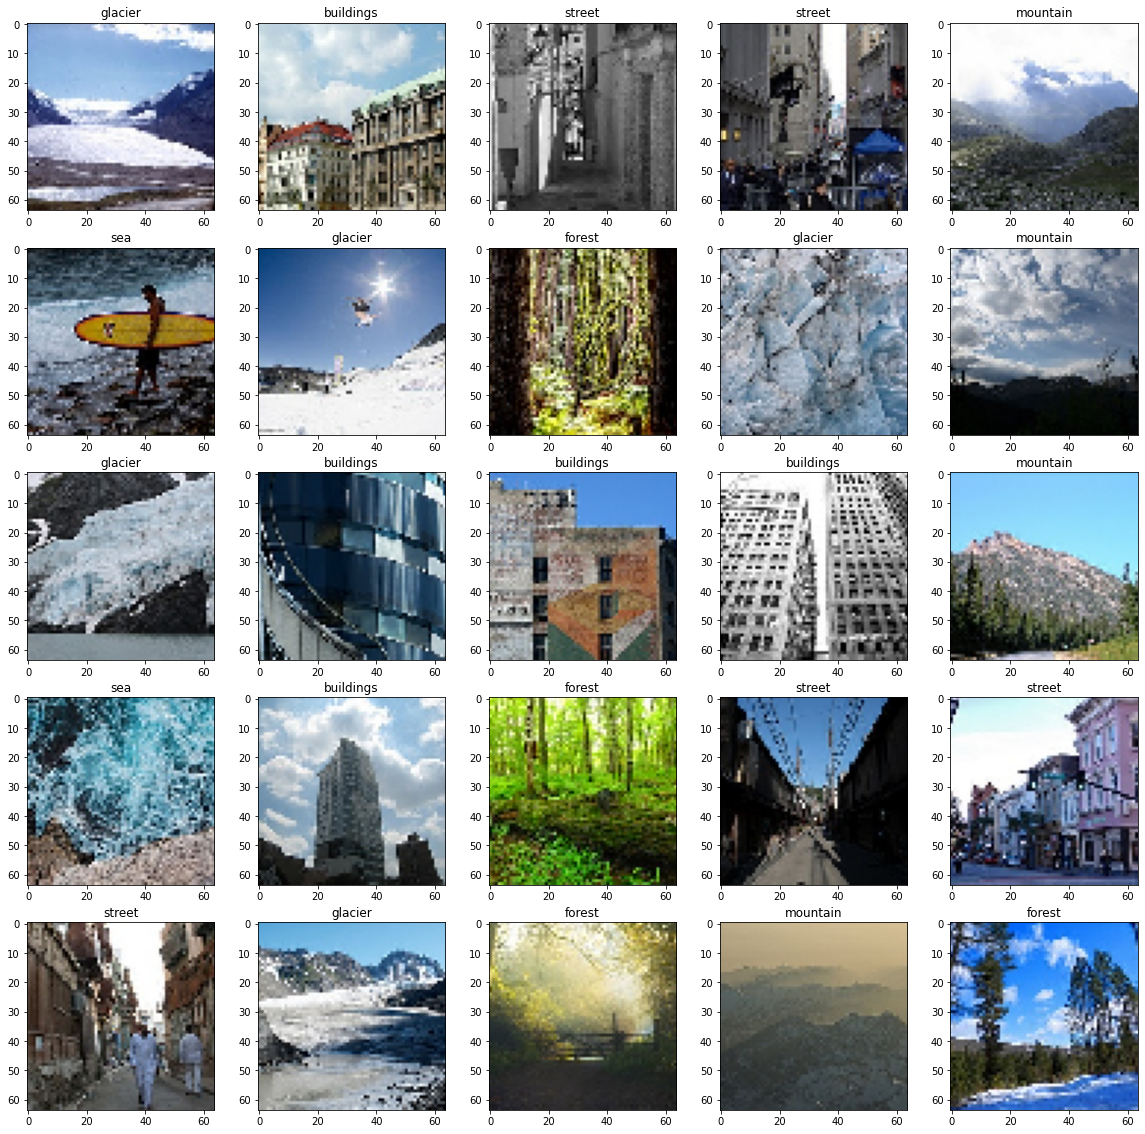

In [ ]:
# Having a look at some of the images from training set
fig , ax = plt.subplots(5,5,figsize = (20,20))
idx = 0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[idx])
        ax[i][j].title.set_text(y_train[idx])
        idx+=1

<H3><b>DATA AUGMENTATION (DA) </b></H3> 
<h5>Data Augmentation is really important for our problem statement as our target is Natural scenes classification for UAV's and for any flying object, the images they perceive would be different in the sense of - </h5>
<ul>
<li>Rotation(to identify scenes from different angles), </li>
<li>Zooming (to classify images from different flying range),</li>
<li>Brightness (to classify during different weather conditions where the
brightness would change)</li>
<li> Shear (to slant the shape of the image)</li>
<li> Night vision (to identify images at night)</li>
</ul>

<h5>For this we would separate the images for each class, then randomly choose 200 images from each class. Then merge these 1200 images (200 images from each class) and perform each of the above mentioned data augmentation on this merged arrays of images and then append that to X_train.  </h5>




**DA Step 1** - Separating images from X_train based on class labels (y_train)

In [ ]:
# Applying filters to label_df created
filt_0 = label_df['Label'] == 'buildings'
filt_1 = label_df['Label'] == 'forest'
filt_2 = label_df['Label'] == 'glacier'
filt_3 = label_df['Label'] == 'mountain'
filt_4 = label_df['Label'] == 'sea'
filt_5 = label_df['Label'] == 'street'

# Getting the index of a particular class images
building_idx = label_df[filt_0].index
forest_idx = label_df[filt_1].index
glacier_idx = label_df[filt_2].index
mountain_idx = label_df[filt_3].index
sea_idx = label_df[filt_4].index
street_idx = label_df[filt_5].index

In [ ]:
# Creating separate datasets for each of classes for storing images and it's labels 
building_ds = X_train[building_idx]
building_label = y_train[building_idx]

forest_ds = X_train[forest_idx]
forest_label = y_train[forest_idx]

glacier_ds = X_train[glacier_idx]
glacier_label = y_train[glacier_idx]

mountain_ds = X_train[mountain_idx]
mountain_label = y_train[mountain_idx]

sea_ds = X_train[sea_idx]
sea_label = y_train[sea_idx]

street_ds = X_train[street_idx]
street_label = y_train[street_idx]

In [ ]:
# Checking the number of images in each class
print("NUMBER OF IMAGES AND SIZE OF EACH IMAGE :")
print("*"*40)
print("Buildings: ",building_ds.shape)
print("Forests: ",forest_ds.shape)
print("Glacier: ",glacier_ds.shape)
print("Mountains: ",mountain_ds.shape)
print("Sea: ",sea_ds.shape)
print("Street: ",street_ds.shape)

NUMBER OF IMAGES AND SIZE OF EACH IMAGE :
****************************************
Buildings:  (2191, 64, 64, 3)
Forests:  (2271, 64, 64, 3)
Glacier:  (2404, 64, 64, 3)
Mountains:  (2512, 64, 64, 3)
Sea:  (2274, 64, 64, 3)
Street:  (2382, 64, 64, 3)


In [ ]:
# Selecting 200 images and it's labels from respective class datasets
rand_buildings_ds = building_ds[0:200]
rand_buildings_label = building_label[0:200]

rand_forest_ds = forest_ds[200:400]
rand_forest_label = forest_label[200:400]

rand_glacier_ds = glacier_ds[400:600]
rand_glacier_label = glacier_label[400:600]

rand_mountain_ds = mountain_ds[600:800]
rand_mountain_label = mountain_label[600:800]

rand_sea_ds = sea_ds[800:1000]
rand_sea_label = sea_label[800:1000]

rand_street_ds = street_ds[1000:1200]
rand_street_label = street_label[1000:1200]

In [ ]:
# Merging the 200 images from each class (so total of 1200 images)
rand_merged_img = np.concatenate((rand_buildings_ds,rand_forest_ds,rand_glacier_ds,rand_mountain_ds,rand_sea_ds,rand_street_ds))


# Merging the 200 labels corresponding to images from each class (so total of 1200 labels)
rand_merged_labels = np.concatenate((rand_buildings_label,rand_forest_label,rand_glacier_label,rand_mountain_label,rand_sea_label,rand_street_label))
print("Shape of merged Images : {} | Shape of merged Labels : {}".format(rand_merged_img.shape,rand_merged_labels.shape))

Shape of merged Images : (1200, 64, 64, 3) | Shape of merged Labels : (1200,)


In [ ]:
# Shuffling the rand_merged_img and rand_merged_labels as now it would be in order that is
# first all images would be of one certain class, then other few images of 
# other certain class and so on.
# So shuffling the images and its labels
rand_merged_img, rand_merged_labels = shuffle(rand_merged_img, rand_merged_labels, random_state=0)

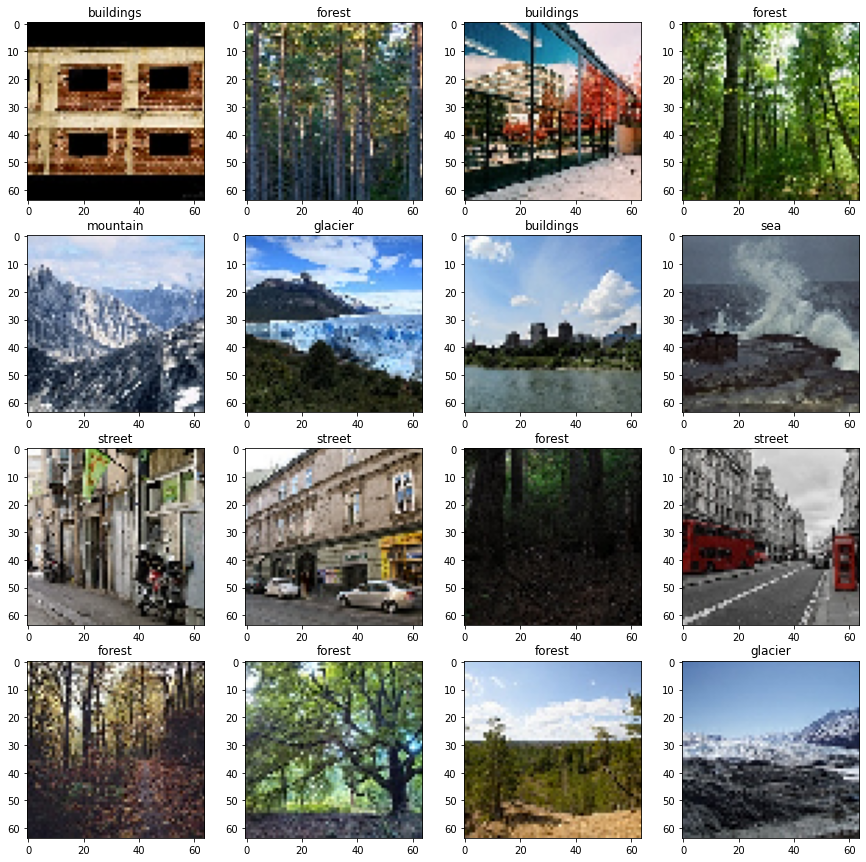

In [ ]:
# Having a look at random images
fig , ax = plt.subplots(4,4,figsize = (15,15))
idx = 0
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(rand_merged_img[idx])
        ax[i][j].title.set_text(rand_merged_labels[idx])
        idx+=1

**DA Step 2** - **Rotation Augmentation** on merged array of 1200 images which contain 200 images of each class 

In [ ]:
# Defining a function for rotating image randomly in an range of 45 degrees
def rot_img(x):
    img = tf.keras.preprocessing.image.random_rotation(x,rg = 45 , channel_axis=2)
    return img

In [ ]:
# Defining a function rot_aug i.e. rotation augmentation which takes input as
# image_array, labels and batch_size and returns rotated images using the above rot_img
# function and labels corresponding to it.
def rot_aug(img , label , batch_size):
    batch_size = batch_size
    rand_rot_ds = []
    rand_rot_label = []
    for i in range(batch_size):
        rds = rot_img(img[i])
        rand_rot_label.append(label[i])
        rand_rot_ds.append(rds)
    return rand_rot_ds, rand_rot_label  

In [ ]:
# Applying the rotation augmentation on rand_merged_img and rand_merged_labels
batch_size = len(rand_merged_img)

# Storing the rotated images in rot_merged_ds and it's labels in  rot_merged_labels
rot_merged_ds, rot_merged_labels = rot_aug(rand_merged_img,rand_merged_labels,batch_size)

In [ ]:
type(rot_merged_labels)

list

In [ ]:
# Converting the rotated images and its labels from list to array so that we can append it to X_train
rot_merged_ds = np.array(rot_merged_ds)
rot_merged_labels = np.array(rot_merged_labels)
print("Shape of Rotated Images : {} | Range of Rotation : {}".format(rot_merged_ds.shape,'45 Degrees'))

Shape of Rotated Images : (1200, 64, 64, 3) | Range of Rotation : 45 Degrees


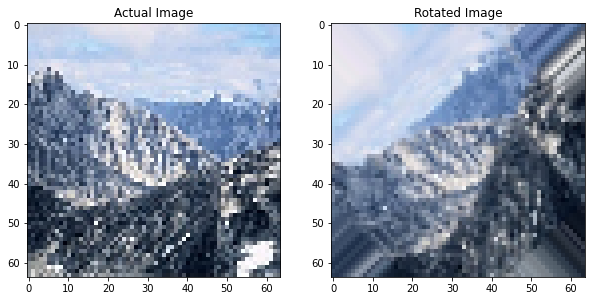

In [ ]:
# Having a look at rotated image at particular index
fig , ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(rand_merged_img[4])
ax[0].title.set_text("Actual Image")
ax[1].imshow(rot_merged_ds[4])
ax[1].title.set_text("Rotated Image")

**DA Step 3** - **Brightness Augmentation** on merged array of 1200 images which contain 200 images of each class 

In [ ]:
# Defining a function for brightening image randomly in a range from 1 to 2
def bright_img(x):
    img = tf.keras.preprocessing.image.random_brightness(x,brightness_range = (1,2))
    return img

In [ ]:
# Defining a function bright_aug i.e. bright augmentation which takes input as
# image_array, labels and batch_size and returns brightened images using the above bright_img
# function and labels corresponding to it.
def bright_aug(img , label , batch_size):
    batch_size = batch_size
    rand_bright_ds = []
    rand_bright_label = []
    for i in range(batch_size):
        bds = bright_img(img[i] / 255)
        rand_bright_label.append(label[i])
        rand_bright_ds.append(bds)
    return rand_bright_ds , rand_bright_label    

In [ ]:
# Applying the brightness augmentation on rand_merged_img and rand_merged_labels
batch_size = len(rand_merged_img)

# Storing the brightened images in bright_merged_ds and it's labels in  bright_merged_labels
bright_merged_ds, bright_merged_labels = bright_aug(rand_merged_img,rand_merged_labels,batch_size)

In [ ]:
# Converting the brightened images and its labels from list to array so that we can append it to X_train
bright_merged_ds = np.array(bright_merged_ds)
bright_merged_labels = np.array(bright_merged_labels)
print("Shape of Augmented Images : {} | Range of Brightness : {}".format(bright_merged_ds.shape,'1-2'))

Shape of Augmented Images : (1200, 64, 64, 3) | Range of Brightness : 1-2


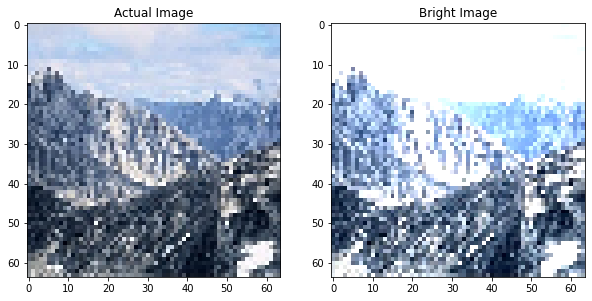

In [ ]:
# Having a look at bright image at particular index
fig , ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(rand_merged_img[4])
ax[0].title.set_text("Actual Image")
ax[1].imshow(bright_merged_ds[4] / 255)
ax[1].title.set_text("Bright Image")

**DA Step 4** - **Zoom Augmentation** on merged array of 1200 images which contain 200 images of each class 

In [ ]:
# Defining a function for zooming image randomly in a range of 0.8 for both width as well as height
def zoom_img(x):
    img = tf.keras.preprocessing.image.random_zoom(x,zoom_range = (0.8,0.8) , channel_axis=2)
    return img

In [ ]:
# Defining a function zoom_aug i.e. zoom augmentation which takes input as
# image_array, labels and batch_size and returns zoomed images using the above zoom_img
# function and labels corresponding to it.
def zoom_aug(img , label , batch_size):
    batch_size = batch_size
    rand_zoom_ds = []
    rand_zoom_label = []
    for i in range(batch_size):
        zds = zoom_img(img[i])
        rand_zoom_label.append(label[i])
        rand_zoom_ds.append(zds)
    return rand_zoom_ds , rand_zoom_label  

In [ ]:
# Applying the zoom augmentation on rand_merged_img and rand_merged_labels
batch_size = len(rand_merged_img)

# Storing the zoomed images in zoom_merged_ds and it's labels in  zoom_merged_labels
zoom_merged_ds, zoom_merged_labels = zoom_aug(rand_merged_img,rand_merged_labels,batch_size)

In [ ]:
# Converting the zoomed images and its labels from list to array so that we can append it to X_train
zoom_merged_ds = np.array(zoom_merged_ds)
zoom_merged_labels = np.array(zoom_merged_labels)
print("Shape of Augmented Images : {} | Zoom Range: {}".format(zoom_merged_ds.shape,'0.8-0.8'))

Shape of Augmented Images : (1200, 64, 64, 3) | Zoom Range: 0.8-0.8


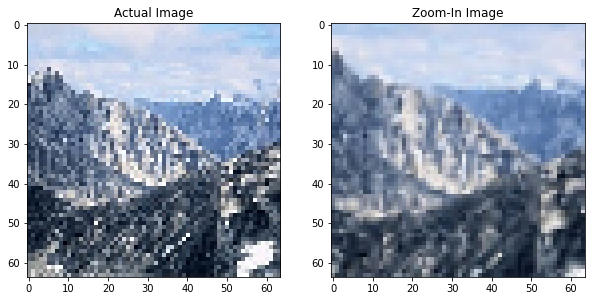

In [ ]:
# Having a look at zoomed in image at particular index
fig , ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(rand_merged_img[4])
ax[0].title.set_text("Actual Image")
ax[1].imshow(zoom_merged_ds[4])
ax[1].title.set_text("Zoom-In Image")

**DA Step 5** - **Shear Augmentation** on merged array of 1200 images which contain 200 images of each class <br>
* **Shear Augmentation**: Performs a random spatial shear of a Numpy image tensor.

In [ ]:
# Defining a function for performing random shear on image with an
# transformation intensity of 35 degrees
def shear_img(x):
    img = tf.keras.preprocessing.image.random_shear(x,intensity=35 , channel_axis=2)
    return img

In [ ]:
# Defining a function shear_aug i.e. shear augmentation which takes input as
# image_array, labels and batch_size and returns sheared images using the above shear_img
# function and labels corresponding to it.
def shear_aug(img , label , batch_size):
    batch_size = batch_size
    rand_shear_ds = []
    rand_shear_label = []
    for i in range(batch_size):
        sds = shear_img(img[i])
        rand_shear_label.append(label[i])
        rand_shear_ds.append(sds)
    return rand_shear_ds , rand_shear_label  

In [ ]:
# Applying the shear augmentation on rand_merged_img and rand_merged_labels
batch_size = len(rand_merged_img)

# Storing the sheared images in shear_merged_ds and it's labels in  shear_merged_labels
shear_merged_ds, shear_merged_labels = shear_aug(rand_merged_img,rand_merged_labels,batch_size)

In [ ]:
# Converting the shear images and its labels from list to array so that we can append it to X_train
shear_merged_ds = np.array(shear_merged_ds)
shear_merged_labels = np.array(shear_merged_labels)
print("Shape of Augmented Images : {} | Shear Intensity: {}".format(shear_merged_ds.shape,'35'))

Shape of Augmented Images : (1200, 64, 64, 3) | Shear Intensity: 35


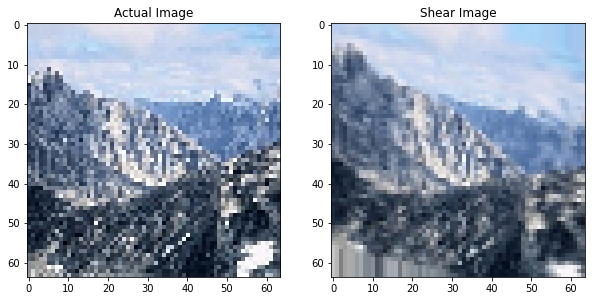

In [ ]:
# Having a look at shear image at particular index
fig , ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(rand_merged_img[4])
ax[0].title.set_text("Actual Image")
ax[1].imshow(shear_merged_ds[4])
ax[1].title.set_text("Shear Image")

**DA Step 6** - **Night Vision Augmentation** on merged array of 1200 images which contain 200 images of each class
*  Since most of the images are in daylight scene, we thought it would be appropriate to train the model on images without a daylight setup. We defined a funtion **night_view** to do the augmentation 


In [ ]:
# Defining a function that would adjust image's RGB values to give it's night view
def night_view(img_array):
    """
    Takes input image as numpy array and returns equivalent night vision of that image.
    """
    night_img = img_array * np.array([0.1, 1.5, 1.2])
    night_array = (255*night_img/night_img.max()).astype(np.uint8)
    return night_array

In [ ]:
# Applying the nigt_view function on rand_merg_img
rand_night_img = night_view(rand_merged_img)

In [ ]:
# Converting images and its labels to arrays 
night_merged_ds = np.array(rand_night_img)
# Labels would remain same as shear_merged_labels as same 1200 
# images and labels are used
night_merged_labels = np.array(shear_merged_labels)
print("Shape of Augmented Images : {} ".format(shear_merged_ds.shape))

Shape of Augmented Images : (1200, 64, 64, 3) 


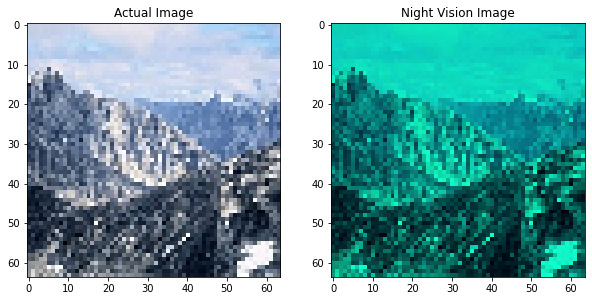

In [ ]:
# Having a look at night vision image at particular index
fig , ax = plt.subplots(1,2, figsize = (10,10))

ax[0].imshow(rand_merged_img[4])
ax[0].title.set_text("Actual Image")
ax[1].imshow(night_merged_ds[4])
ax[1].title.set_text("Night Vision Image")

**DA Step 7** - Appending this augmented images to X_train and it's labels to y_train

In [ ]:
# Merging the augmented images to X_train
X_train_new = np.concatenate((X_train,rot_merged_ds,bright_merged_ds,zoom_merged_ds,shear_merged_ds ,night_merged_ds))
print("Shape of new X_train which contains augmented images too: ",X_train_new.shape)

Shape of new X_train which contains augmented images too:  (20034, 64, 64, 3)


In [ ]:
# Merging the augmented labels to y_train
y_train_new = np.concatenate((y_train,rot_merged_labels,bright_merged_labels,zoom_merged_labels,shear_merged_labels ,night_merged_labels))
print("Shape of new y_train which contains augmented image labels too: ",y_train_new.shape)

Shape of new y_train which contains augmented image labels too:  (20034,)


**DA Step 8** - Shuffling the X_train_new and y_train_new.

In [ ]:
# Shuffling the X_train_new and y_train_new and storing the new training data in X and y
X , y = shuffle(X_train_new, y_train_new, random_state=0)

**DA Step 9** - One hot encoding the labels in y and y_test using to_categorical. 

In [ ]:
# Defining a function to convert classes at a given index to its respective key
# numbers using the scenedict 
def get_key(IDX):
    for k in scenedict.keys():
        if scenedict.get(k) == IDX:
            return k

In [ ]:
# Converting y to list from ndarray
y = y.tolist()

# Getting the keys corresponding it's classes using scenedict 
# and get_key function 
Y = [get_key(i) for i in y]

# One-hot encoding Y and storing it in Y_
Y_ = to_categorical(Y)
print("Shape of encoded Y : {}".format(Y_.shape))

Shape of encoded Y : (20034, 6)


In [ ]:
# # Getting the keys corresponding it's classes using scenedict 
# and get_key function for y_test
y_test = [get_key(i) for i in y_test]

# One-hot encoding y_test and storing it in Y_test
Y_test = to_categorical(y_test)

print("Shape of encoded Y_test : {}".format(Y_test.shape))

Shape of encoded Y_test : (3000, 6)


<H3><b>MODEL ARCHITECTURES </b></H3> 
Tried 3 model architectures which are -<br>

*   **Model_1**-  Custom Architecture model with 6 Conv2D, 3 MaxPooling Layers and 3 Dropout layers (increasing filters after every 2 Convolution layers)
*   **Model_2**-  Custom Architecture model with using BatchNormalization.
*   **Model_3**-  Pre-trained VGG model

**Model_1** - Custom Architecture model with **6 Conv2D**, **3 MaxPooling Layers** and **3 Dropout layers** (increasing filters after every 2 Convolution layers)

In [ ]:
# Custom Architecture model with 6 Conv2D (increasing filters after every 2 Convolution layers)
def Model_1():
    new_model = Sequential()

    # First convolution layer
    new_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
    # Second convolution layer
    new_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # First max-pooling layer
    new_model.add(MaxPooling2D(pool_size=(2,2)))
    new_model.add(Dropout(0.25))

    # Third convolution layer
    new_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    # Fourth convolution layer
    new_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # Second max-pooling layer
    new_model.add(MaxPooling2D(pool_size=(2,2)))
    new_model.add(Dropout(0.25))

    # Fifth convolution layer
    new_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    # Sixth convolution layer
    new_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # Third max-pooling layer
    new_model.add(MaxPooling2D(pool_size=(2,2)))
    new_model.add(Dropout(0.25))

    # Flatten layer
    new_model.add(Flatten())

    # Fully connected dense layer
    new_model.add(Dense(1024,activation='relu'))

    new_model.add(Dense(128,activation='relu'))
    # Output layer
    new_model.add(Dense(6,activation='sigmoid'))

    # Compiling the model
    new_model.compile(optimizer = tf.keras.optimizers.Adam(),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    return new_model
    

In [ ]:
# Summary of Model_1
Model_1 = Model_1()
Model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                        

                                               MODEL MAPS : MODEL_1


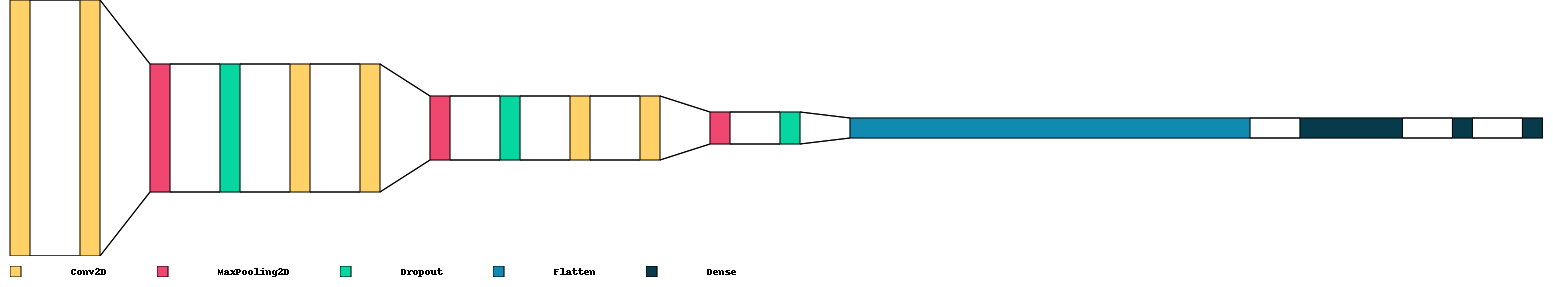

In [ ]:
# visualising model architecture 
print("                                               MODEL MAPS : MODEL_1")
visualkeras.layered_view(Model_1 , legend = True,spacing=50,draw_volume=False) 

In [ ]:
epoch = 15
BS = 50

In [ ]:
history_model1 = Model_1.fit(X,Y_ , epochs = epoch , validation_split = 0.2 , batch_size = BS)

Epoch 1/15
321/321 [==============================] - 21s 47ms/step - loss: 1.6673 - accuracy: 0.3150 - val_loss: 1.1102 - val_accuracy: 0.5458
Epoch 2/15
321/321 [==============================] - 14s 45ms/step - loss: 1.0641 - accuracy: 0.5607 - val_loss: 0.9758 - val_accuracy: 0.6042
Epoch 3/15
321/321 [==============================] - 14s 44ms/step - loss: 0.9566 - accuracy: 0.6140 - val_loss: 0.9483 - val_accuracy: 0.6239
Epoch 4/15
321/321 [==============================] - 14s 43ms/step - loss: 0.8807 - accuracy: 0.6446 - val_loss: 0.8522 - val_accuracy: 0.6633
Epoch 5/15
321/321 [==============================] - 14s 43ms/step - loss: 0.8111 - accuracy: 0.6854 - val_loss: 0.7755 - val_accuracy: 0.7015
Epoch 6/15
321/321 [==============================] - 14s 45ms/step - loss: 0.7379 - accuracy: 0.7175 - val_loss: 0.7472 - val_accuracy: 0.7125
Epoch 7/15
321/321 [==============================] - 14s 45ms/step - loss: 0.6759 - accuracy: 0.7450 - val_loss: 0.6396 - val_accuracy:

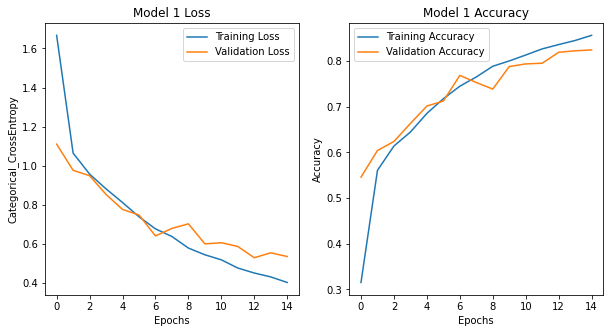

In [ ]:
fig , ax  = plt.subplots(1,2 , figsize = (10,5))
ax[0].plot(range(0,epoch),history_model1.history['loss'],label = 'Training Loss')
ax[0].plot(range(0,epoch),history_model1.history['val_loss'] , label = 'Validation Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Categorical_CrossEntropy")
ax[0].title.set_text("Model 1 Loss")
ax[0].legend()
ax[1].plot(range(0,epoch),history_model1.history['accuracy'],label = 'Training Accuracy')
ax[1].plot(range(0,epoch),history_model1.history['val_accuracy'] , label = 'Validation Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].title.set_text("Model 1 Accuracy")
ax[1].legend()

**Model_2** - Custom Architecture model with using **BatchNormalization**.

In [ ]:
def Model_2():
    #BLOCK-1#
    model = tf.keras.Sequential(name = 'Model_2')
    model.add(Conv2D(32,(3,3),padding='same',input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    #BLOCK-2#
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))


    #BLOCK-3#
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    #BLOCK-4#
    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    #BLOCK-5#
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    #BLOCK-6#
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    #BLOCK-7#
    model.add(Dense(6))
    model.add(Activation('softmax'))
    
    # Compiling the model
    model.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [ ]:
# Summary of Model_2
Model_2 = Model_2()
Model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                       

                                               MODEL MAPS : MODEL_2


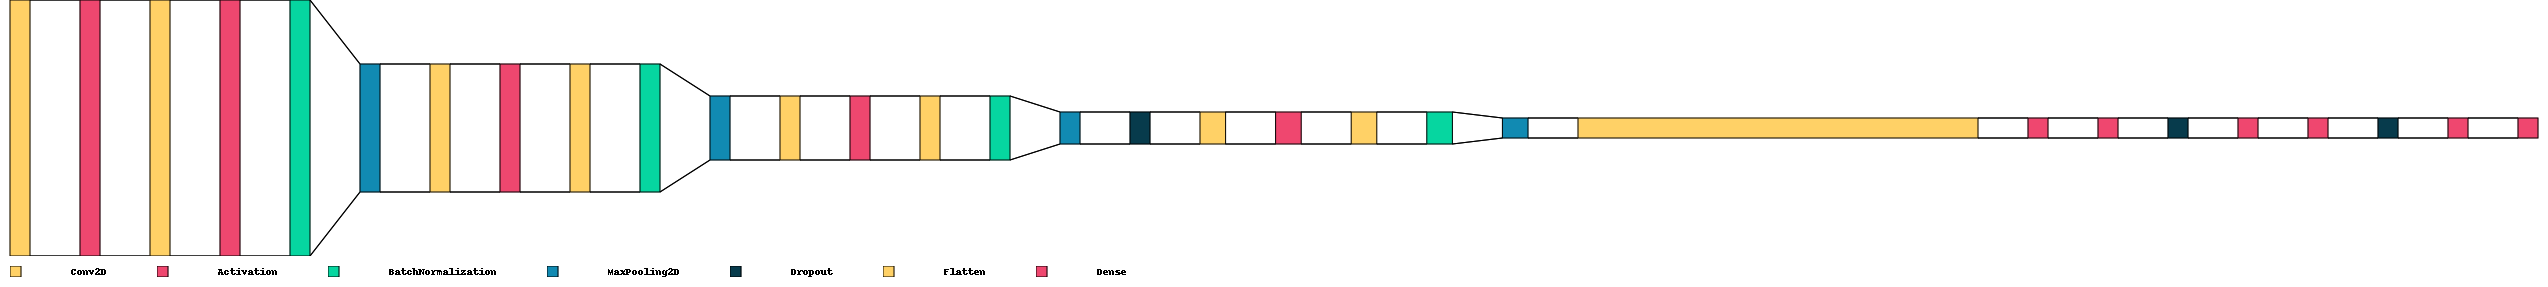

In [ ]:
# visualising model architecture 
print("                                               MODEL MAPS : MODEL_2")
visualkeras.layered_view(Model_2 , legend = True,spacing=50,draw_volume=False) 

In [ ]:
# history_model2 = Model_2.fit(X,Y_ , epochs = epoch , validation_split = 0.2 , batch_size = BS)

![Garph_model2.png](attachment:Garph_model2.png)

In [ ]:
# fig , ax  = plt.subplots(1,2 , figsize = (10,5))
# ax[0].plot(range(0,epoch),history_model2.history['loss'],label = 'Training Loss')
# ax[0].plot(range(0,epoch),history_model2.history['val_loss'] , label = 'Validation Loss')
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Categorical_CrossEntropy")
# ax[0].title.set_text("Model 2 Loss")
# ax[0].legend()
# ax[1].plot(range(0,epoch),history_model2.history['accuracy'],label = 'Training Accuracy')
# ax[1].plot(range(0,epoch),history_model2.history['val_accuracy'] , label = 'Validation Accuracy')
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Accuracy")
# ax[1].title.set_text("Model 2 Accuracy")
# ax[1].legend()

**Model 3** - Pre-trained **VGG Model**.

In [ ]:
def VGG():
    conv_base=VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(64,64,3))
    model=Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(6,activation='softmax'))

    model.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    return model 

In [ ]:
# Summary of Model_3
Model_3 = VGG()
Model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 15,240,774
Trainable params: 15,240,774
Non-trainable params: 0
_________________________________________________________________


                                               MODEL MAPS : VGG


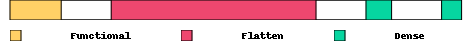

In [ ]:
# visualising model architecture 
print("                                               MODEL MAPS : VGG")
visualkeras.layered_view(Model_3, legend = True,spacing=50,draw_volume=False) 

In [ ]:
# history_vgg = Model_3.fit(X,Y_ , epochs = epoch , validation_split = 0.2 , batch_size = BS)

![VGG_Graph.png](attachment:VGG_Graph.png)

In [ ]:
# fig , ax  = plt.subplots(1,2 , figsize = (10,5))
# ax[0].plot(range(0,epoch),history_vgg.history['loss'],label = 'Training Loss')
# ax[0].plot(range(0,epoch),history_vgg.history['val_loss'] , label = 'Validation Loss')
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Categorical_CrossEntropy")
# ax[0].title.set_text("VGG Model Loss")
# ax[0].legend()
# ax[1].plot(range(0,epoch),history_vgg.history['accuracy'],label = 'Training Accuracy')
# ax[1].plot(range(0,epoch),history_vgg.history['val_accuracy'] , label = 'Validation Accuracy')
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Accuracy")
# ax[1].title.set_text("VGG Model Accuracy")
# ax[1].legend()

**Trained all the above three models in different notebooks on X and Y_ and stored it and its weights to avoid retraining of models everytime we run this notebook.**

You can find the link to the pretrained models here:

https://drive.google.com/drive/folders/1f7j_aH_qJ-J24ND-9bjNIh2KDgIdQl0Y?usp=sharing

**Loading the saved models -**

In [ ]:
# Loading Model_1
# model_1 = tf.keras.models.load_model("Model_1.h5")

# Loading Model_2
model_2 = tf.keras.models.load_model("Model_2.h5")

# Loading Model_3
VGG = tf.keras.models.load_model("Model_vgg.h5")

<h3><b>Evaluating Models</b></h3>

**Model_1 Evaluation -**

In [ ]:
# Checking the train and test accuracy
Model1_train_accuracy = Model_1.evaluate(X[:800],Y_[:800])

25/25 [==============================] - 1s 6ms/step - loss: 0.2729 - accuracy: 0.9038


In [ ]:
model1_test_accuracy = Model_1.evaluate(X_test,Y_test)

94/94 [==============================] - 1s 7ms/step - loss: 0.5463 - accuracy: 0.8220


In [ ]:
print("Model_1 train accuracy: ",Model1_train_accuracy[1])
print("Model_1 test accuracy: ",model1_test_accuracy[1])

Model_1 train accuracy:  0.9037500023841858
Model_1 test accuracy:  0.8220000267028809


In [ ]:
# Using Model_1 for predicting on X_test
y_pred = Model_1.predict(X_test)

In [ ]:
# Converting the probabilities to classes
prediction = [np.argmax(y_pred[i]) for i in range(0, len(y_pred))]

# Classification report
print("                CLASSIFICATION REPORT OF MODEL 1")
print(classification_report(y_test , prediction))

                CLASSIFICATION REPORT OF MODEL 1
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       437
           1       0.93      0.96      0.94       474
           2       0.77      0.78      0.77       553
           3       0.78      0.76      0.77       525
           4       0.77      0.86      0.81       510
           5       0.88      0.81      0.84       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



**Model_2 Evaluation -**

In [ ]:
# Checking the train and test accuracy
model2_train_accuracy = model_2.evaluate(X[:500],Y_[:500])


16/16 [==============================] - 1s 36ms/step - loss: 0.5985 - accuracy: 0.7740


In [ ]:
model2_test_accuracy = model_2.evaluate(X_test,Y_test)

94/94 [==============================] - 2s 21ms/step - loss: 0.5999 - accuracy: 0.7793


In [ ]:
print("Model_2 train accuracy: ",model2_train_accuracy[1])
print("Model_2 test accuracy: ",model2_test_accuracy[1])

Model_2 train accuracy:  0.7739999890327454
Model_2 test accuracy:  0.7793333530426025


In [ ]:
# Using Model_2 for predicting on X_test
y_pred = model_2.predict(X_test)

In [ ]:
# Converting the probabilities to classes
prediction = [np.argmax(y_pred[i]) for i in range(0, len(y_pred))]

# Classification report
print("                CLASSIFICATION REPORT OF MODEL 2")
print(classification_report(y_test , prediction))

                CLASSIFICATION REPORT OF MODEL 2
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       437
           1       0.93      0.95      0.94       474
           2       0.67      0.82      0.74       553
           3       0.69      0.70      0.70       525
           4       0.89      0.52      0.65       510
           5       0.83      0.86      0.85       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



**Model_3 (VGG) Evaluation -**

In [ ]:
# Checking the train and test accuracy
vgg_train_accuracy = VGG.evaluate(X[:500],Y_[:500])



16/16 [==============================] - 1s 17ms/step - loss: 0.5985 - accuracy: 0.7740


In [ ]:
vgg_test_accuracy = VGG.evaluate(X_test[:500],Y_test[:500])

16/16 [==============================] - 0s 16ms/step - loss: 0.5718 - accuracy: 0.7940


In [ ]:
print("Model_3 train accuracy: ",vgg_train_accuracy[1])
print("Model_3 test accuracy: ",vgg_test_accuracy[1])

Model_3 train accuracy:  0.7739999890327454
Model_3 test accuracy:  0.7940000295639038


In [ ]:
# Using Model_3 (VGG) for predicting on X_test
y_pred = VGG.predict(X_test)

In [ ]:
# Converting the probabilities to classes
prediction = [np.argmax(y_pred[i]) for i in range(0, len(y_pred))]

# Classification report
print("                CLASSIFICATION REPORT OF VGG Model")
print(classification_report(y_test , prediction))

                CLASSIFICATION REPORT OF VGG Model
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       437
           1       0.93      0.95      0.94       474
           2       0.67      0.82      0.74       553
           3       0.69      0.70      0.70       525
           4       0.89      0.52      0.65       510
           5       0.83      0.86      0.85       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000



<H4><B>MODEL SELECTION</B></H4>

**FEATURE MAPS**

In [ ]:
# Function to plot the input image and the true and predicted labels
test_idx = 1200
def pred(test_idx):
    x_test_1 = X_test[test_idx].reshape(1,64,64,3)
    y_pred = Model_1.predict(x_test_1).reshape(-1).tolist()
    y_test_1 = Y_test[test_idx].reshape(-1,).tolist()
    PRED = scenedict[y_pred.index(max(y_pred))]
    ACTUAL = scenedict[y_test_1.index(max(y_test_1))]
    plt.imshow(x_test_1[0])
    plt.title("ACTUAL : {} | PREDICTION : {}".format(ACTUAL, PRED))
    return ACTUAL

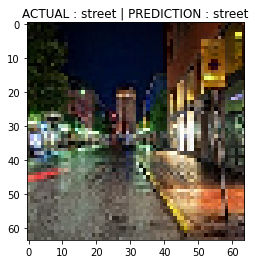

In [ ]:
# Predicting on test image at a specific image
actual = pred(1200)

In [ ]:
# Defining a function to visualize the feature map in 3x3 grid 
def get_feature_maps(nrows , ncols , activation ):
    fig, ax = plt.subplots(nrows,ncols,figsize = (6,6))
    idx=0
    for i in range(0,nrows):
        temp = idx
        idx = temp
        for j in range(0,ncols):
            z = activation[0]
            ax[i][j].imshow(z.squeeze()[:,:,idx] , cmap = 'viridis')
            idx+=1 

##### FEATURE MAP for FIRST CONV_LAYER

In [ ]:
# Defining the output layer 
layer0_output = Model_1.layers[0].output      

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output) 

 # reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)      

# Collecting the output of model at the defined output layer in layer0_output
activations = activation_model.predict(img)  

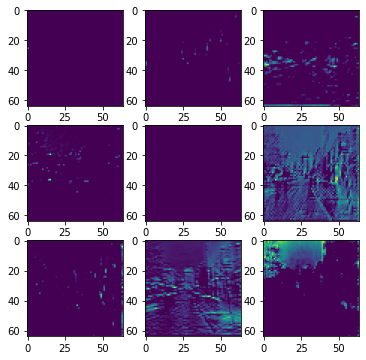

In [ ]:
# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

##### FEATURE MAPS for SECOND CONV LAYER

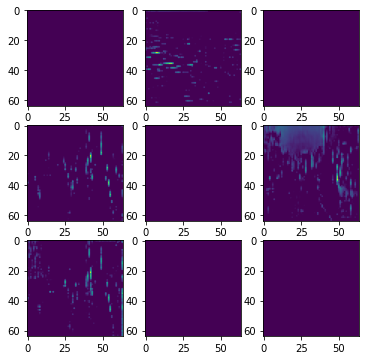

In [ ]:
# Defining the output layer 
layer0_output = Model_1.layers[1].output  

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output)  

# Reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)        

# Collecting the output of model at the defined output layer in layer0_output 
activations = activation_model.predict(img) 

# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

##### FEATURE MAPS for THIRD CONV LAYER 

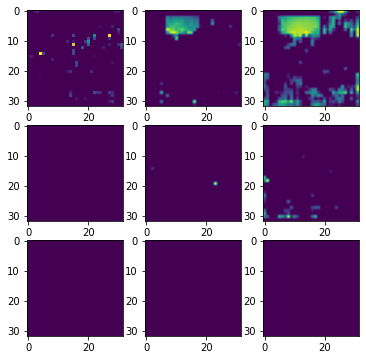

In [ ]:
#FEATURE MAP THIRD CONV LAYER 
# Defining the output layer 
layer0_output = Model_1.layers[4].output  

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output)  

# Reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)        

# Collecting the output of model at the defined output layer in layer0_output 
activations = activation_model.predict(img) 

# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

##### FEATURE MAPS for FOURTH CONV LAYER 

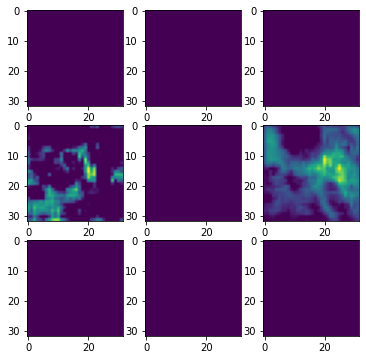

In [ ]:
# Defining the output layer 
layer0_output = Model_1.layers[5].output  

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output)  

# Reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)        

# Collecting the output of model at the defined output layer in layer0_output 
activations = activation_model.predict(img) 

# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

##### FEATURE MAPS for FIFTH CONV LAYER 

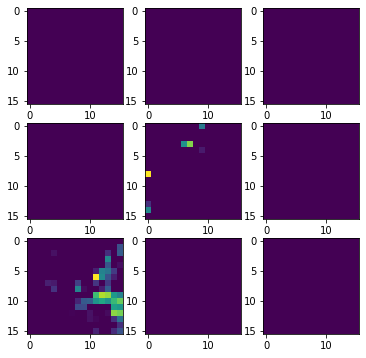

In [ ]:
# Defining the output layer 
layer0_output = Model_1.layers[8].output  

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output)  

# Reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)        

# Collecting the output of model at the defined output layer in layer0_output 
activations = activation_model.predict(img) 

# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

##### FEATURE MAPS for SIXTH CONV LAYER 

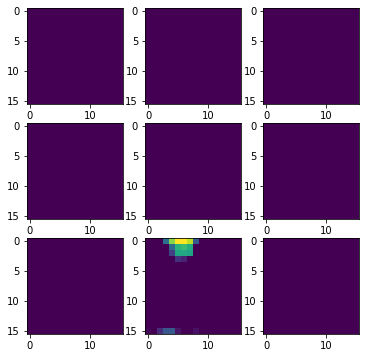

In [ ]:
# Defining the output layer 
layer0_output = Model_1.layers[9].output  

#Defining the activation  model 
activation_model = tf.keras.Model(Model_1.input ,layer0_output)  

# Reshaping the input image
img = X_test[test_idx].reshape(1,64,64,3)        

# Collecting the output of model at the defined output layer in layer0_output 
activations = activation_model.predict(img) 

# Using the get_feature_maps function defined above
get_feature_maps(3,3, activations)

**SALIENCY MAPS AND GradCAM Visualization**

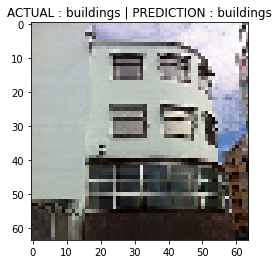

In [ ]:
# Predicting on test image at a specific image and viewing it
# Using this image for visualizing saliency maps
actual = pred(325)

In [ ]:
img = X_test[325]
img.shape

(64, 64, 3)

In [ ]:
# # Defining a function for replacing the function in the last layer to a
# # linear activation function because when the softmax activation function 
# # is applied to the last layer of model,it may obstruct generating the attention images
def model_modifier_function(cloned_model):
     cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
# using get_key() funtion to access the key corresponding to the actual label to pass in the score
score = CategoricalScore(get_key(actual))

Text(0.5, 1.0, 'Vanilla Saliency Map')

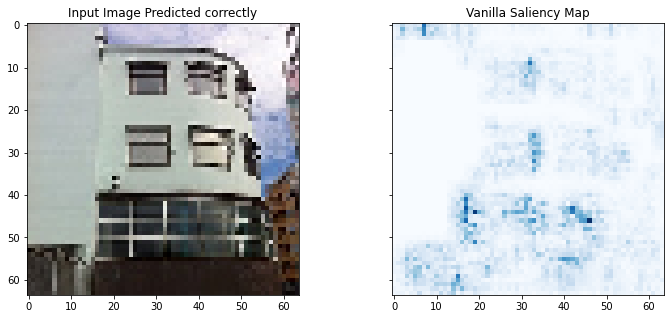

In [ ]:
###### VANILLA SALIENCY ######
# Creating Saliency object.
saliency = Saliency(Model_1,
                    model_modifier=model_modifier_function(Model_1),
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, img)

# Normalizing saliency map
saliency_map = normalize(saliency_map)

# Storing the the saliency map in vanilla_saliency
vanilla_saliency = saliency_map[0]

# Plotting the iput image and vanilla saliency map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
ax[0].imshow(img)
ax[0].set_title('Input Image Predicted correctly')
ax[1].imshow(vanilla_saliency, cmap='Blues')
ax[1].set_title('Vanilla Saliency Map')

Text(0.5, 1.0, 'SmoothGrad Saliency Map')

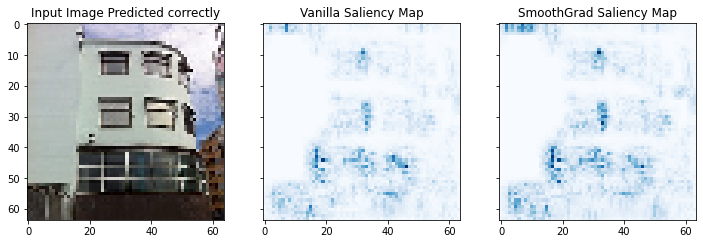

In [ ]:
###### SmoothGrad Saliency Map ########
# Generating saliency map with smoothing that reduce noise by adding noise
# for the same input image used above
saliency_map = saliency(score,
                        img,
                        smooth_samples=10, # The number of calculating gradients iterations.
                        smooth_noise=0.02) # noise spread level.

## Normalizing the saliency map
saliency_map = normalize(saliency_map)

# Storing the SmoothGrad saliency map in sg_saliency
sg_saliency = saliency_map[0]

# Plotting the iput image, vanilla saliency map and SmoothGrad Saliency map
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True)
ax[0].imshow(img)
ax[0].set_title('Input Image Predicted correctly')
ax[1].imshow(vanilla_saliency, cmap='Blues')
ax[1].set_title('Vanilla Saliency Map')
ax[2].imshow(sg_saliency, cmap='Blues')
ax[2].set_title('SmoothGrad Saliency Map')

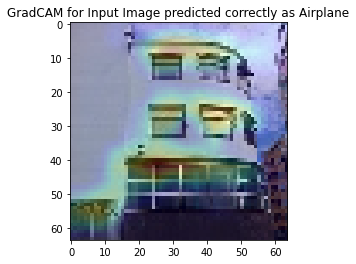

In [ ]:
###### GradCAM #########
# Creating Gradcam object
gradcam = Gradcam(Model_1,
                  model_modifier=model_modifier_function(Model_1),
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              img,
              penultimate_layer=-1)

## Normalizing the heatmap
cam = normalize(cam)

# Plotting by imposing the heatmap of Image
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet',alpha=0.2) # overlay
plt.title('GradCAM for Input Image predicted correctly as Airplane')
plt.show()

Text(0.5, 0.98, 'Saliency Map and GradCAM for input image predicted correctly as Mountain')

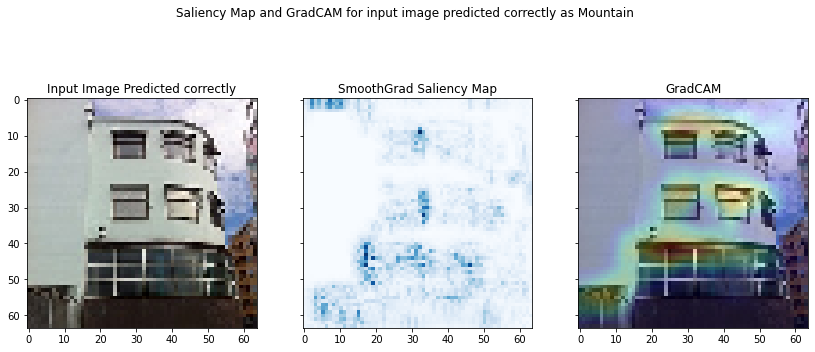

In [ ]:
# Plotting the original image,SmoothGrad Saliency map and GradCAM
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharex=True, sharey=True)
ax[0].imshow(img)
ax[0].set_title('Input Image Predicted correctly')
ax[1].imshow(sg_saliency, cmap='Blues')
ax[1].set_title('SmoothGrad Saliency Map')
ax[2].imshow(img)
ax[2].imshow(heatmap, cmap='jet',alpha=0.2)
ax[2].set_title('GradCAM')
fig.suptitle('Saliency Map and GradCAM for input image predicted correctly as Mountain')

From all the above 2 plots, it can seen the smoothgrad saliency map is good in showing us which part of the image is being focused by the model to classify the input image correctly. From the GradCam it can be noticed that the model is focused on the features of the building like edges and windows. Hence making a correct prediction. 

<h2><U><b>APPROACH 2</b></U> </h2>

In [ ]:
import cv2

In [ ]:
train_path = r"C:\Users\UMANG\AI-2\Project\seg_train"
test_path = r"C:\Users\UMANG\AI-2\Project\seg_test"

In [ ]:
folders = os.listdir(train_path)
folders

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
def req_operations():
    operations = [rot_img,bright_img,zoom_img,shear_img,night_view]
    num_operations = np.random.randint(2,6)
    apply_operations= random.sample(operations,num_operations)
    return apply_operations

In [ ]:
for folder in folders:
    images= os.listdir(train_path+"//"+folder)
    for image in images:
        image_path = train_path+"//"+folder+ "//"+image
        img = load_img(image_path,target_size=(150,150))
        img = img_to_array(img)
        ops = req_operations()
        for op in ops:
            img = op(img)
        cv2.imwrite(train_path+"//"+folder+ "//"+image[:-4]+"_process.jpg", img)

In [ ]:
for folder in folders:
    images= os.listdir(test_path+"//"+folder)
    for image in images:
        image_path = test_path+"//"+folder+ "//"+image
        img = load_img(image_path,target_size=(150,150))
        img = img_to_array(img)
        ops = req_operations()
        for op in ops:
            img = op(img)
        cv2.imwrite(test_path+"//"+folder+ "//"+image[:-4]+"_process.jpg", img)

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

Found 28068 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.


In [ ]:
# Custom Architecture model with 6 Conv2D (increasing filters after every 2 Convolution layers)
# def Model_1():
new_model = Sequential()

# First convolution layer
new_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
# Second convolution layer
new_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

# First max-pooling layer
new_model.add(MaxPooling2D(pool_size=(2,2)))
new_model.add(Dropout(0.25))

# Third convolution layer
new_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
# Fourth convolution layer
new_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Second max-pooling layer
new_model.add(MaxPooling2D(pool_size=(2,2)))
new_model.add(Dropout(0.25))

# Fifth convolution layer
new_model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
# Sixth convolution layer
new_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Third max-pooling layer
new_model.add(MaxPooling2D(pool_size=(2,2)))
new_model.add(Dropout(0.25))

# Flatten layer
new_model.add(Flatten())

# Fully connected dense layer
new_model.add(Dense(1024,activation='relu'))

new_model.add(Dense(128,activation='relu'))
# Output layer
new_model.add(Dense(6,activation='sigmoid'))

# Compiling the model
new_model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
# return new_model

In [ ]:
history = new_model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        batch_size = 50)

Epoch 1/15
1755/1755 [==============================] - 79s 45ms/step - loss: 1.1060 - accuracy: 0.5581 - val_loss: 0.9249 - val_accuracy: 0.6368
Epoch 2/15
1755/1755 [==============================] - 79s 45ms/step - loss: 0.8047 - accuracy: 0.6909 - val_loss: 0.7467 - val_accuracy: 0.7193
Epoch 3/15
1755/1755 [==============================] - 78s 45ms/step - loss: 0.6790 - accuracy: 0.7479 - val_loss: 0.6864 - val_accuracy: 0.7378
Epoch 4/15
1755/1755 [==============================] - 78s 45ms/step - loss: 0.5896 - accuracy: 0.7838 - val_loss: 0.7264 - val_accuracy: 0.7337
Epoch 5/15
1755/1755 [==============================] - 78s 45ms/step - loss: 0.5095 - accuracy: 0.8121 - val_loss: 0.7048 - val_accuracy: 0.7470
Epoch 6/15
1755/1755 [==============================] - 78s 45ms/step - loss: 0.4271 - accuracy: 0.8452 - val_loss: 0.7174 - val_accuracy: 0.7577
Epoch 7/15
1755/1755 [==============================] - 79s 45ms/step - loss: 0.3582 - accuracy: 0.8697 - val_loss: 0.8045 -

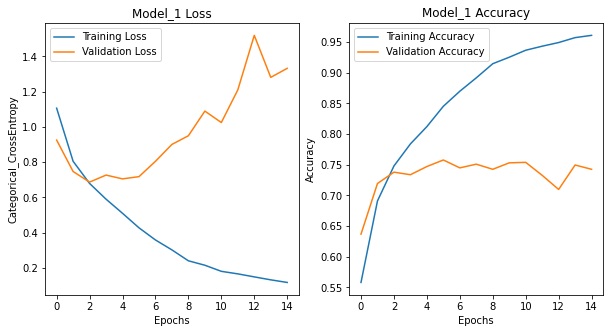

In [ ]:
# Plotting the training and validation accuracy and loss and accuracy
fig , ax  = plt.subplots(1,2 , figsize = (10,5))
ax[0].plot(range(0,15),history.history['loss'],label = 'Training Loss')
ax[0].plot(range(0,15),history.history['val_loss'] , label = 'Validation Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Categorical_CrossEntropy")
ax[0].title.set_text("Model_1 Loss")
ax[0].legend()
ax[1].plot(range(0,15),history.history['accuracy'],label = 'Training Accuracy')
ax[1].plot(range(0,15),history.history['val_accuracy'] , label = 'Validation Accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].title.set_text("Model_1 Accuracy")
ax[1].legend()

In [ ]:
# Selecting one batch of 16 images for prediction and model evaluation 
img = []
label = []
idx = 0
for image , labels in validation_generator:
    img.append(image)
    label.append(labels)
    break

In [ ]:
# evaluating the model
validation_result = new_model.evaluate(img[0],label[0])[1]
print("Validation Accuracy : ",validation_result)   #printing the validation accuracy

1/1 [==============================] - 0s 329ms/step - loss: 0.4990 - accuracy: 0.7500
Validation Accuracy :  0.75


In [ ]:
# predictions
pred = new_model.predict(img[0])         #Predicting for one batch of images i.e. 16 images

In [ ]:
# defining a function to return the correspomdimg class of a predicted index
def get_key(IDX):
    for k in train_generator.class_indices.keys():
        if train_generator.class_indices.get(k) == IDX:
            return k

In [ ]:
# Converting a array of predicted probabilities to list of labels 
predict = []
for i in pred:
    p = np.argmax(i)
    predict.append(get_key(p))

In [ ]:
# conveeting a array of one hot encoded lists to labels 
True_label = []
for i in labels:
    p = np.argmax(i)
    True_label.append(get_key(p))

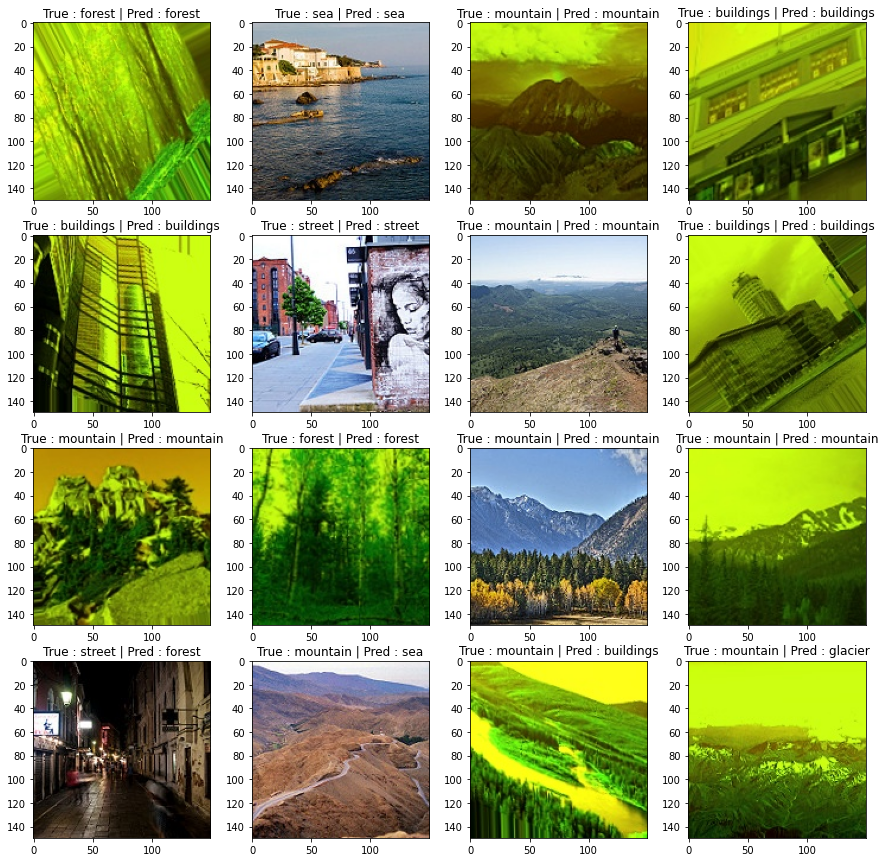

In [ ]:
# visualising the batch of images against its true and predicted labels
fig , ax = plt.subplots(4,4 , figsize = (15,15))
idx = 0
for i in range(0,4):
    temp = idx
    idx = temp
    for j in range(0,4):
        ax[i][j].imshow(img[0][idx])
        ax[i][j].set_title("True : {} | Pred : {}".format(True_label[idx],predict[idx]))
        idx+=1